# Submission 4

Gargeya Sharma - 2202780025 - MSc Artificial Intelligence

### 1.)

/opt/conda/lib/python3.10/site-packages/pandas_datareader/wb.py:592: UserWarning: Non-standard ISO country codes: WLD
  warnings.warn(


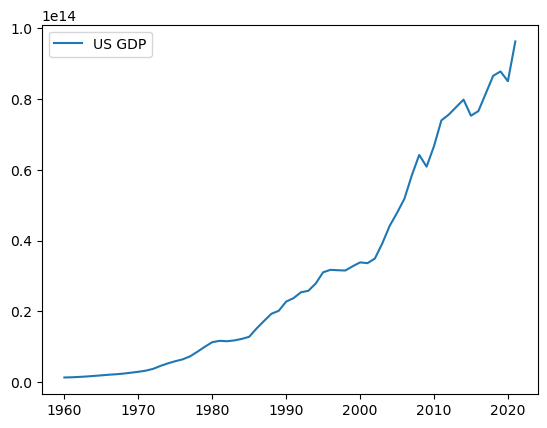

In [2]:
from pandas_datareader import wb
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from tqdm.notebook import tqdm

gdp_data = wb.download(indicator = 'NY.GDP.MKTP.CD', country="WLD", start='1960', end='2021')
time = np.arange(1960, 2022)
gdp = gdp_data.iloc[:,0].astype(float).to_numpy()
gdp = np.flip(gdp)

plt.plot(time, gdp, label="US GDP")
plt.legend()
plt.show()

The transformation we can use is taking **log** at both sides. That changes the nature of given relationship into linear.

Transformed Equation looks like: ---> (2)
$$
\log{GDP_{k}} = \log{GDP_{0}} + k \log{(1+r)}
$$


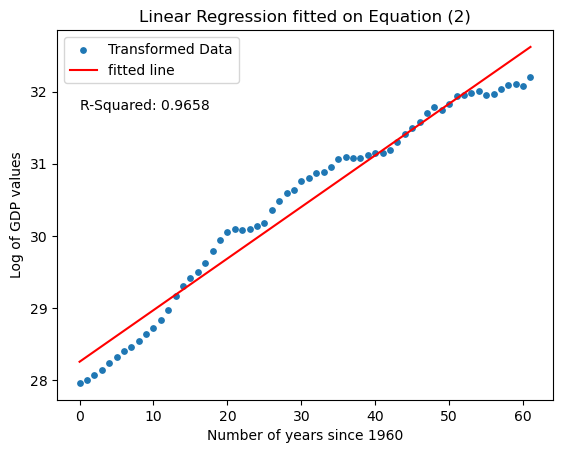

In [8]:
## Number of years since 1960 (time[0] == 1960)
k = time-time[0]
reg = stats.linregress(k, np.log(gdp))

## Keeping x-axis as difference of years (k) between a particular year and 1960
#          y-axis as log of GDP values

# Trasforming the data by taking log on GDP values
plt.scatter(k, np.log(gdp), label='Transformed Data', s=15)

# Getting predictions from the fitted regression model
pred = reg.intercept + reg.slope*k

plt.plot(k, pred, 'r', label='fitted line')
plt.text(0,31.75, f"R-Squared: {reg.rvalue**2 :.4f}")
plt.xlabel("Number of years since 1960")
plt.ylabel("Log of GDP values")
plt.title("Linear Regression fitted on Equation (2)")
plt.legend()
plt.show()

#### Work with Residuals

In [9]:
res = pred - np.log(gdp)
print(f"Mean of the residuals: {np.mean(res) :.4f}")
print(f"Standard Deviation of residuals: {np.std(res) :.4f}")

Mean of the residuals: -0.0000
Standard Deviation of residuals: 0.2411


In [10]:
## Normal Distribution 'norm' with mean = 0 and std = 0.2411
norm = stats.norm(loc=0, scale=np.std(res))

## Performed KS-Test with the residual values on Normal distributions stated above
ks_stats, p_value = stats.kstest(res, norm.cdf)
print(f"P-value produced from KS-test: {p_value}")

P-value produced from KS-test: 0.22644562327630569


In [11]:
# For a two-sided test:
# alpha (given) = 99% = 0.99
# significant p-value = (1-alpha)/2 ==> 0.05

print(f"NULL Hypothesis:  the residuals are sampled from a normal distribution with mean = 0 and standard deviation = {np.std(res):.4f}\n\n")

if p_value < 0.05:
    print(f"Reject the Null Hypothesis")
else:
    print(f"Can NOT reject the Null Hypothesis")

NULL Hypothesis:  the residuals are sampled from a normal distribution with mean = 0 and standard deviation = 0.2411


Can NOT reject the Null Hypothesis


#### Revert the Transformation

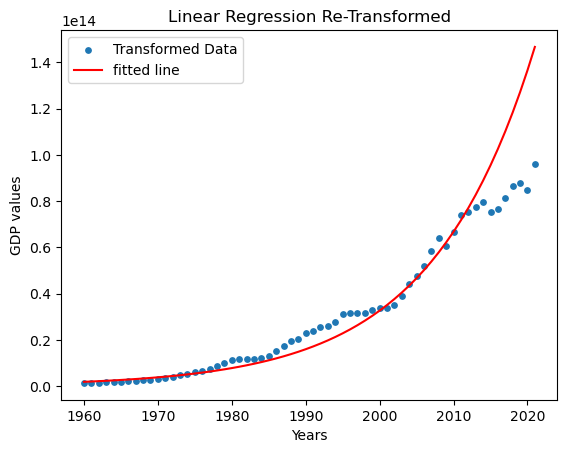

In [12]:
inv_pred = np.exp(pred)
plt.scatter(time, gdp, label='Transformed Data', s=15)

# Getting predictions from the fitted regression model

plt.plot(time, inv_pred, 'r', label='fitted line')
plt.xlabel("Years")
plt.ylabel("GDP values")
plt.title("Linear Regression Re-Transformed")
plt.legend()
plt.show()

The relationship between the slop of the regression and long-term growth rate of the world GDP (r):

$$
  slope = \log{(1+r)}
$$

In [13]:
r = np.exp(reg.slope) - 1
print(f"Long Term Growth rate of the world GDP: {r:.4f} or {r*100:.2f}%")

Long Term Growth rate of the world GDP: 0.0742 or 7.42%


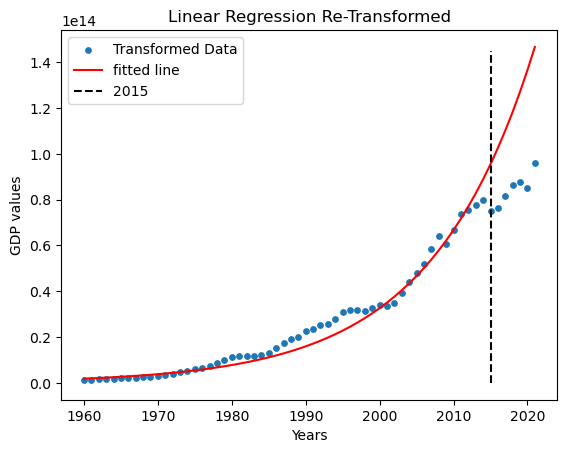

In [14]:
inv_pred = np.exp(pred)
plt.scatter(time, gdp, label='Transformed Data', s=15)

# Getting predictions from the fitted regression model

plt.plot(time, inv_pred, 'r', label='fitted line')
plt.vlines(2015, 0, 1.45e+14, color="black", label="2015", linestyles="dashed" )
plt.xlabel("Years")
plt.ylabel("GDP values")
plt.title("Linear Regression Re-Transformed")
plt.legend()
plt.show()

##### Observation:

Approximately around 2015, the fitted regression line and the data are drifting apart from each other in direction. Until this period from 1960, the model is closely capturing the nature of the data and we can say with high confidence that the model is a good fit. Further on, their slopes are growing differently hence resulting in poor model fitting. (*Discretization Error*)

### 2.)

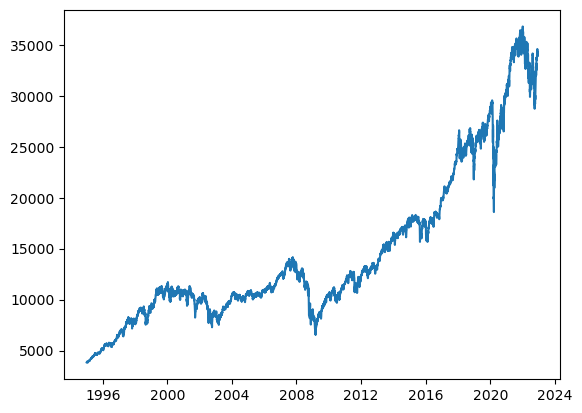

In [15]:
import pandas_datareader.data as web

data = web.DataReader('^DJI','yahoo' , start='1995-01-01', end='2022-12-05')
data = data.reset_index()
dates = data["Date"]
dow = data["Close"].to_numpy()
plt.plot(dates, dow)
plt.show()

In [16]:
def autocorrelation(x,y):
    numer = np.sum((x-np.mean(x))*(y-np.mean(y)))
    denom = np.sqrt(np.sum(((x-np.mean(x))**2))*np.sum(((y-np.mean(y))**2)))
    return numer/denom

In [17]:
lags = [1,2,3,5,10,15,20,30]
K = 60 # Days
autocrr = []
auto = []
for lag in tqdm(lags):
    for i in range(len(dow)-K-lag+1):
        autocrr.append(autocorrelation(dow[i:i+K], dow[i+lag: i+lag+K]))
    auto.append(autocrr)
auto = np.array(auto)
print(auto.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

(8, 55698)


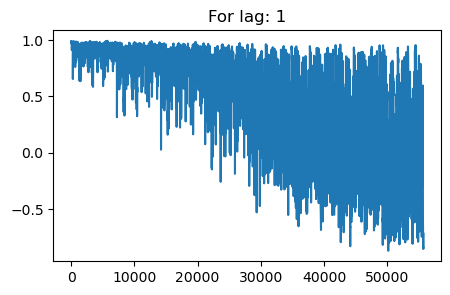

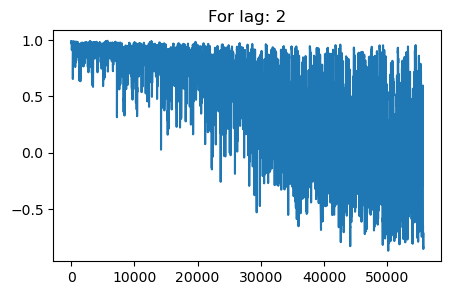

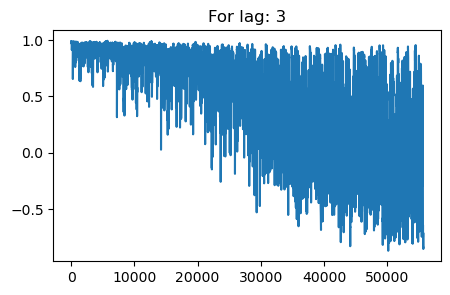

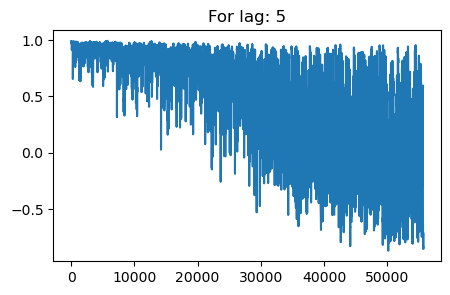

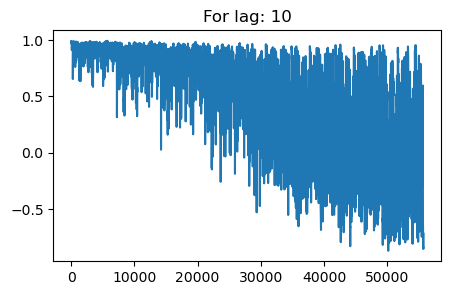

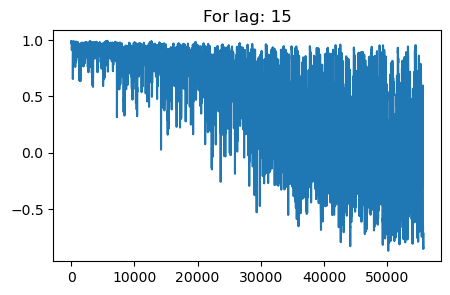

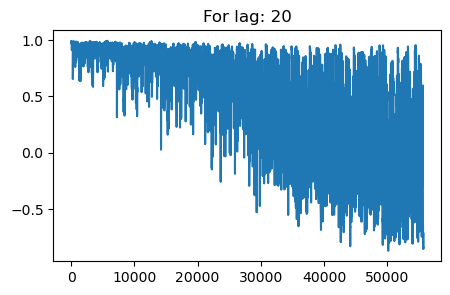

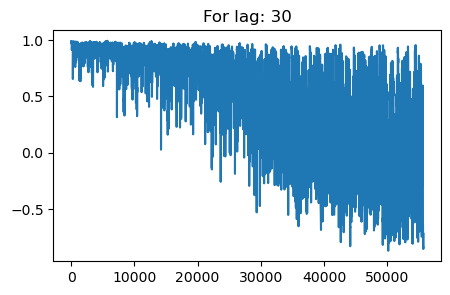

In [20]:
for i in range(auto.shape[0]):
    plt.figure(figsize=(5,3))
    plt.plot(auto[i])
    plt.title(f"For lag: {lags[i]}")
    plt.show()

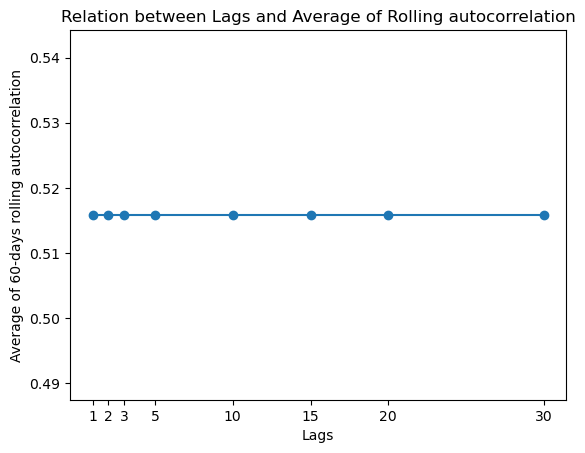

In [18]:
mean_auto = np.mean(auto, axis=1)
plt.plot(lags, mean_auto)
plt.scatter(lags, mean_auto)
plt.xlabel("Lags")
plt.xticks(lags)
plt.ylabel("Average of 60-days rolling autocorrelation")
plt.title("Relation between Lags and Average of Rolling autocorrelation")
plt.show()

**Answer :**

I observe a constant average value (~0.517) of autocorrelation for each lag in lags, that's why the plot between lags and average of autocorrelation is a horizontal straight line.

The plot suggests that the Dow Jones is **NOT** a white noise process. If we reduce this constant average autocorrelation value from all the rolling autocorrelation values for all lag in lags, we will get a constant mean of 0, which is one of the properties of white noise (zero correlation with all the other values in the series)

In [19]:
## Producing Daily Return values

close = data["Close"]
ret = close.copy()[1:]
ret[:] = ((close[1:].values/close[:-1].values)-1)*100
ret.shape

(7031,)

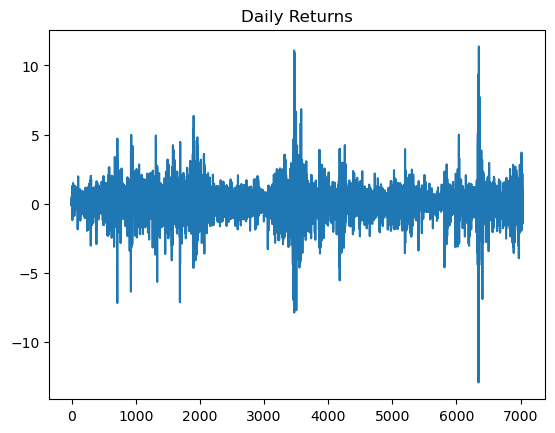

In [20]:
plt.plot(ret)
plt.title("Daily Returns")
plt.show()

In [26]:
lags = [1,2,3,5,10,15,20,30]
K = 60
autocrr1 = []
auto1 = []

for lag in tqdm(lags):
    for i in range(len(ret)-K-lag+1):
        autocrr1.append(autocorrelation(ret[i:i+K], ret[i+lag: i+lag+K]))
    auto1.append(autocrr1)
auto1 = np.array(auto1)
print(auto1.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

(8, 55690)


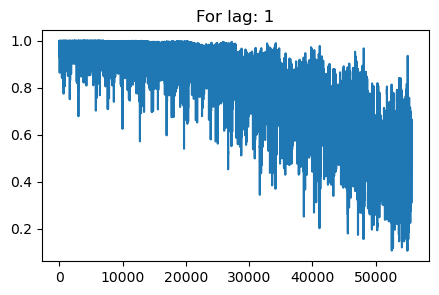

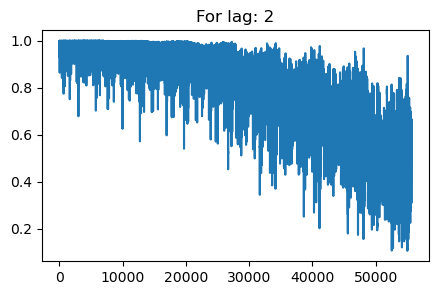

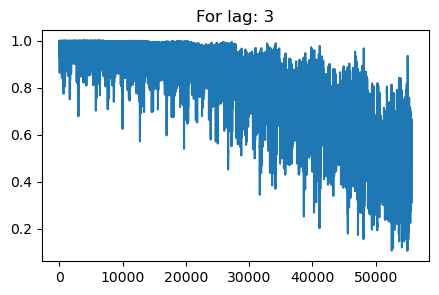

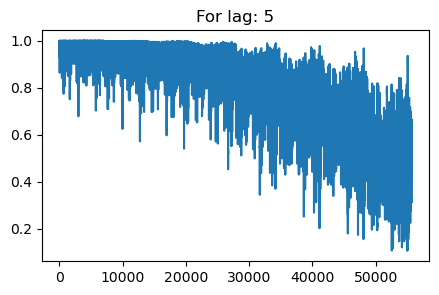

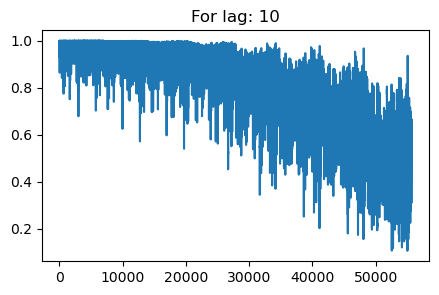

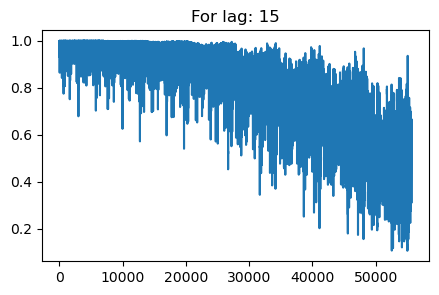

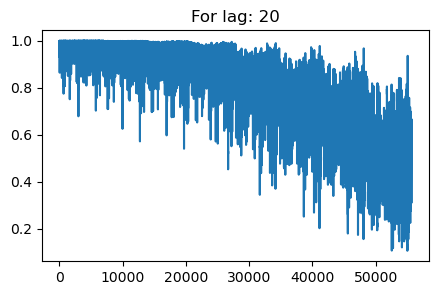

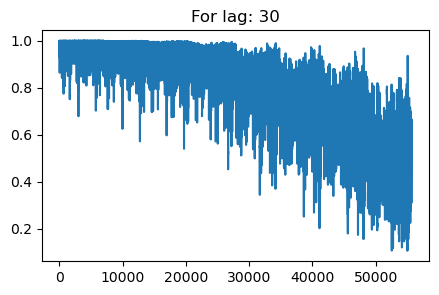

In [29]:
for i in range(auto1.shape[0]):
    plt.figure(figsize=(5,3))
    plt.plot(auto1[i])
    plt.title(f"For lag: {lags[i]}")
    plt.show()

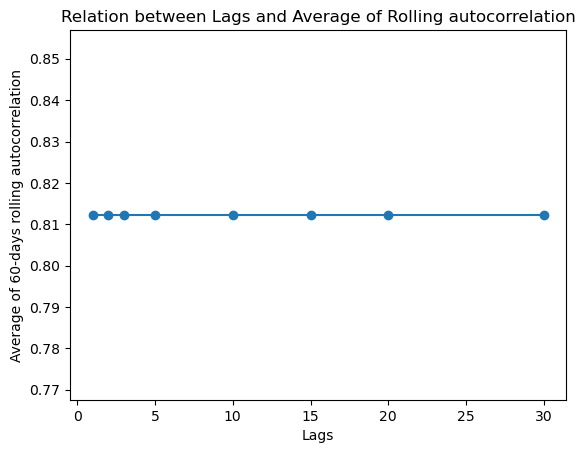

In [31]:
mean_auto = np.mean(auto1, axis=1)
plt.plot(lags, mean_auto)
plt.scatter(lags, mean_auto)
plt.xlabel("Lags")
plt.ylabel("Average of 60-days rolling autocorrelation")
plt.title("Relation between Lags and Average of Rolling autocorrelation")
plt.show()

**Answer :**

I observe a constant average value (~0.812) of autocorrelation for each lag in lags, that's why the plot between lags and average of autocorrelation is a horizontal straight line.

The plot suggests that the Daily Returns is **NOT** a white noise process. If we subtract this constant average autocorrelation value from all the rolling autocorrelation values for all lag in lags, we will get a constant mean of 0, which is one of the properties of white noise (zero correlation with all the other values in the series)

---